In [19]:
import geopandas as gpd
import pandas as pd

# 1) Load NUTS **polygons** (RG), not BN lines
#   Use the RG layer matching your scale/CRS, e.g. 01M in EPSG:3035
# we can find it at: https://gisco-services.ec.europa.eu/distribution/v2/nuts/shp/NUTS_RG_01M_2021_3035.shp.zip
nuts = gpd.read_file("NUTS_RG_01M_2021_3035/NUTS_RG_01M_2021_3035.shp")[["NUTS_ID", "LEVL_CODE", "geometry"]]

# Pick your level: 2 or 3. You had 3 before, so keep it.
nuts2 = nuts[nuts["LEVL_CODE"] == 2].copy()

# 2) Load WWF **polygons**
#   Can be found at: https://figshare.com/ndownloader/files/37264516
eco = gpd.read_file("WWF ecoregions/wwf_terr_ecos.shp")[["ECO_NAME", "ECO_ID", "geometry"]]

# 3) Reproject WWF to match NUTS (EPSG:3035 here)
eco = eco.to_crs(nuts2.crs)

# 4) Quick geometry fixes (helps avoid empty intersections from slight invalidities)
nuts2["geometry"] = nuts2.buffer(0)
eco["geometry"]  = eco.buffer(0)

# 5) Spatial intersection (polygon ∩ polygon)
overlay = gpd.overlay(nuts2, eco, how="intersection", keep_geom_type=True)

# Keep only polygonal results (paranoia check)
overlay = overlay[overlay.geom_type.isin(["Polygon", "MultiPolygon"])].copy()

# 6) Compute area shares per NUTS
#    EPSG:3035 is meter-based; area / 1e6 => km²
overlay["area_km2"] = overlay.geometry.area / 1e6

# Guard against zero/empty geometries
overlay = overlay[overlay["area_km2"] > 0].copy()

# Total NUTS area (sum of intersected pieces equals original, modulo slivers)
total_area = overlay.groupby("NUTS_ID", as_index=False)["area_km2"].sum().rename(columns={"area_km2": "total_area_km2"})

overlay = overlay.merge(total_area, on="NUTS_ID", how="left")
overlay["share_in_nuts"] = overlay["area_km2"] / overlay["total_area_km2"]

# (Optional) sanity checks
assert overlay["share_in_nuts"].between(0, 1).all()


In [20]:
def rebuild_shares(nuts2_gdf: gpd.GeoDataFrame, eco_gdf: gpd.GeoDataFrame):
    # 1) CRS alignment + geometry clean
    eco = eco_gdf.to_crs(nuts2_gdf.crs).copy()
    nuts2 = nuts2_gdf.copy()
    nuts2["geometry"] = nuts2.buffer(0)
    eco["geometry"] = eco.buffer(0)

    # 2) Intersection
    inter = gpd.overlay(nuts2[["NUTS_ID","geometry"]], eco[["ECO_ID","geometry"]], how="intersection", keep_geom_type=True)
    inter = inter[inter.geom_type.isin(["Polygon","MultiPolygon"])].copy()

    # 3) Dissolve by (NUTS_ID, ECO_ID) to avoid duplicate pieces
    inter = inter.dissolve(by=["NUTS_ID","ECO_ID"], as_index=False)

    # 4) Areas
    nuts_area = nuts2[["NUTS_ID","geometry"]].copy()
    nuts_area["nuts_area_km2"] = nuts_area.geometry.area / 1e6

    inter["eco_area_km2"] = inter.geometry.area / 1e6
    overlay_new = inter.merge(nuts_area[["NUTS_ID","nuts_area_km2"]], on="NUTS_ID", how="left")
    overlay_new["share_in_nuts_raw"] = overlay_new["eco_area_km2"] / overlay_new["nuts_area_km2"]

    # 5) Optional: renormalize per NUTS (recommended if tiny overlaps inflate sum slightly)
    sums = overlay_new.groupby("NUTS_ID")["share_in_nuts_raw"].sum().rename("sum_shares")
    overlay_new = overlay_new.merge(sums, on="NUTS_ID", how="left")
    # If sum_shares > 1 (from overlaps), scale down to 1; if <1 (coastal water), leave as is.
    overlay_new["share_in_nuts"] = overlay_new.apply(
        lambda r: r["share_in_nuts_raw"] / r["sum_shares"] if r["sum_shares"] > 1 else r["share_in_nuts_raw"], axis=1
    )

    return overlay_new[["NUTS_ID","ECO_ID","geometry","eco_area_km2","nuts_area_km2","share_in_nuts","sum_shares"]]


In [21]:
nuts2["nuts_area_km2"] = nuts2.geometry.area / 1e6
sum_overlay = overlay.groupby("NUTS_ID")["area_km2"].sum().rename("sum_intersections_km2")
chk = nuts2.merge(sum_overlay, on="NUTS_ID", how="left")

chk["rel_diff"] = (chk["sum_intersections_km2"] - chk["nuts_area_km2"]) / chk["nuts_area_km2"]
# Expect rel_diff close to 0; allow tiny tolerance due to slivers/topology (e.g., ±1%)
bad = chk[chk["rel_diff"].abs() > 0.02]  # investigate these
print("Regions with >2% area mismatch:", len(bad))


Regions with >2% area mismatch: 48


In [23]:
overlay = rebuild_shares(nuts2_gdf=nuts2, eco_gdf=eco)  # use your original nuts2/eco layers
print("Max sum_shares per NUTS2:", overlay.groupby("NUTS_ID")["share_in_nuts"].sum().max())


Max sum_shares per NUTS2: 1.0000000000000002


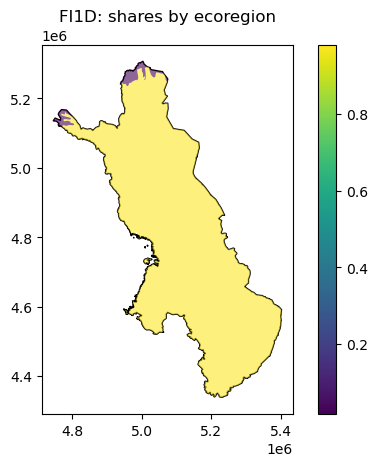

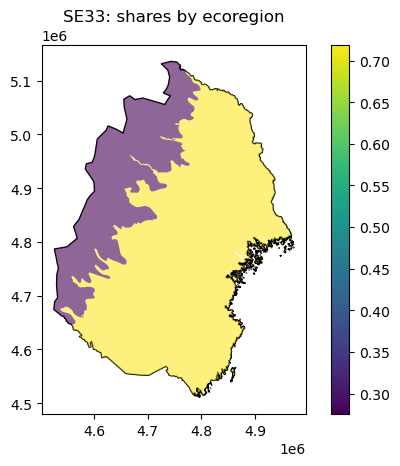

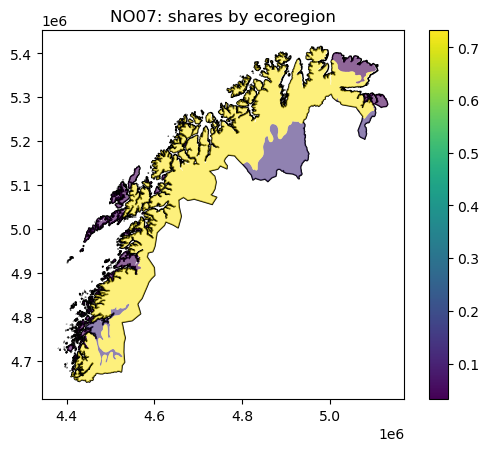

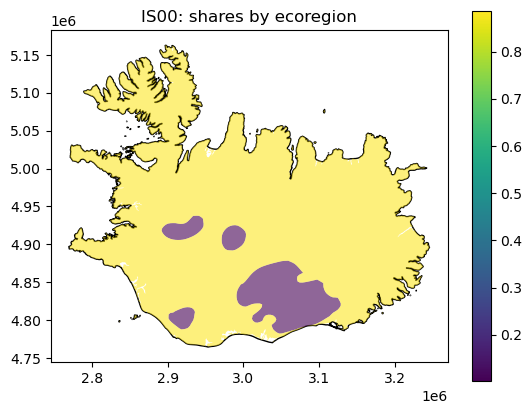

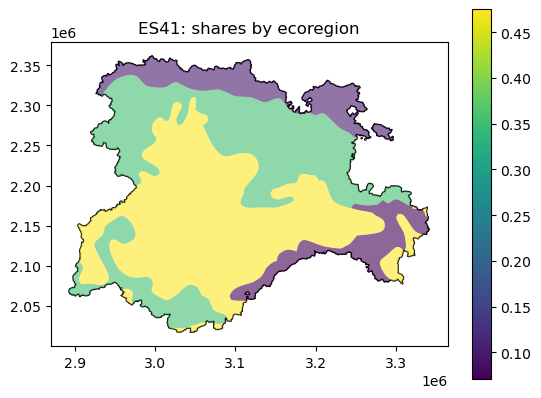

In [24]:
import matplotlib.pyplot as plt
sample_ids = chk.nlargest(5, "nuts_area_km2")["NUTS_ID"].tolist()  # or random sample

for nid in sample_ids:
    base = nuts2[nuts2["NUTS_ID"]==nid]
    parts = overlay[overlay["NUTS_ID"]==nid].copy()
    ax = base.plot(edgecolor="black", facecolor="none", linewidth=1)
    parts.plot(ax=ax, column="share_in_nuts", legend=True, alpha=0.6)
    plt.title(f"{nid}: shares by ecoregion")
    plt.show()


In [27]:
overlay

,NUTS_ID,ECO_ID,geometry,eco_area_km2,nuts_area_km2,share_in_nuts,sum_shares
0,AL01,80404.0,"POLYGON ((5187166.592 2186664.353, 5187876.742...",589.415511,10824.947964,0.054450,0.991854
1,AL01,80418.0,"POLYGON ((5120808.595 2220973.765, 5121180.336...",1888.791953,10824.947964,0.174485,0.991854
2,AL01,81210.0,"MULTIPOLYGON (((5141165.445 2091208.273, 51397...",3098.538051,10824.947964,0.286240,0.991854
3,AL01,81217.0,"MULTIPOLYGON (((5164306.787 2198785.531, 51649...",5160.027206,10824.947964,0.476679,0.991854
4,AL02,81210.0,"MULTIPOLYGON (((5166655.162 2026095.978, 51669...",1649.918650,4966.323444,0.332221,0.996302
...,...,...,...,...,...,...,...
681,UKM7,80503.0,"POLYGON ((3543452.042 3833416.344, 3544088.866...",4172.067290,13401.794731,0.311307,0.986959
682,UKM8,80409.0,"MULTIPOLYGON (((3417165.063 3784208.556, 34173...",1917.339241,1979.979949,0.968363,0.968363
683,UKM9,80409.0,"MULTIPOLYGON (((3420527.343 3606032.195, 34207...",15759.913834,15902.365242,0.991042,0.991042
684,UKN0,80409.0,"MULTIPOLYGON (((3318931.291 3582430.879, 33187...",10919.683751,14157.352662,0.771308,0.984932


In [28]:
import pandas as pd
import re
import numpy as np

in_path = "nama_10r_3gva__custom_18435438_spreadsheet.xlsx"
out_path = "nuts2_added_value_latest.csv"

def clean_number(x):
    """Convert Eurostat-style strings like 1'532.9 to float; ignore flags like 'b','p' in separate cols."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # remove thousands separators (apostrophes or spaces), keep minus and dot/comma
    s = s.replace("'", "").replace(" ", "")
    # convert comma decimal to dot if present
    if s.count(",") == 1 and s.count(".") == 0:
        s = s.replace(",", ".")
    # if it's like "21,626" but also has dot—already handled; if trailing annotations, drop non-numeric tail
    m = re.match(r"^[-+]?\d*\.?\d+(e[+-]?\d+)?$", s, flags=re.IGNORECASE)
    if m:
        try:
            return float(s)
        except Exception:
            return np.nan
    # If contains extra characters, strip non-numeric except dot and minus
    s2 = re.sub(r"[^0-9\.\-eE]", "", s)
    try:
        return float(s2) if s2 not in ("", ".", "-", "-.", ".-") else np.nan
    except Exception:
        return np.nan

def parse_sheet_multiheader(xls, sheet_name, preferred_years):
    # Read with two header rows (row indices 8 and 9 if 1-based row 9 is headers)
    df = pd.read_excel(xls, sheet_name=sheet_name, header=[8,9])
    # Drop completely empty columns
    df = df.dropna(axis=1, how="all")
    # Normalize column labels to strings
    df.columns = pd.MultiIndex.from_tuples(
        [(str(a).strip() if pd.notna(a) else "", str(b).strip() if pd.notna(b) else "") for a,b in df.columns]
    )
    # Find GEO (Codes) column
    code_col = None
    for col in df.columns:
        top, sub = col
        if sub.lower() == "geo (codes)":
            code_col = col
            break
    if code_col is None:
        # Try any level contains GEO (Codes)
        for col in df.columns:
            if "geo (codes)" in " ".join(col).lower():
                code_col = col
                break
    if code_col is None:
        return pd.DataFrame(columns=["nace_code","NUTS2_id","added_value","year_used"])
    
    # Build a dict of year -> value column (pick the first numeric-looking subcolumn among duplicates)
    year_value_cols = {}
    for y in preferred_years:
        # collect columns whose top-level equals the year
        cols = [c for c in df.columns if c[0] == y]
        if not cols:
            continue
        # Among them, pick the one that yields the most numeric values
        best_col = None
        best_non_na = -1
        for c in cols:
            series = df[c].apply(clean_number)
            non_na = series.notna().sum()
            if non_na > best_non_na:
                best_non_na = non_na
                best_col = c
        if best_col is not None and best_non_na > 0:
            year_value_cols[y] = best_col
    
    if not year_value_cols:
        return pd.DataFrame(columns=["nace_code","NUTS2_id","added_value","year_used"])
    
    # For each row, choose latest available year
    recs = []
    for idx, r in df.iterrows():
        nuts = str(r[code_col]).strip().upper()
        if not re.fullmatch(r"[A-Z]{2}[A-Z0-9]{2}", nuts):
            continue
        value = None
        used_year = None
        for y in preferred_years:
            if y in year_value_cols:
                v = clean_number(r[year_value_cols[y]])
                if pd.notna(v):
                    value = float(v); used_year = y
                    break
        if value is not None:
            recs.append({"NUTS2_id": nuts, "added_value": value, "year_used": used_year})
    return pd.DataFrame(recs)

# Collect target sheets
xls = pd.ExcelFile(in_path)
sheet_names = xls.sheet_names
target_sheets = [s for s in sheet_names if re.match(r"^Sheet", str(s), flags=re.IGNORECASE)]

preferred_years = [str(y) for y in range(2023, 1994, -1)]

dict_nace_codes = {
    1: "A",
    2: "C",
    3: "F",
    4: "J",
    5: "K",
    6: "L",
}

all_rows = []
for s in target_sheets:
    m = re.match(r"^Sheet\s*(.+)$", s, flags=re.IGNORECASE)
    nace_code = m.group(1).strip() if m else s.strip()
    part = parse_sheet_multiheader(xls, s, preferred_years)
    if not part.empty:
        part.insert(0, "nace_code", dict_nace_codes[int(nace_code)])
        all_rows.append(part)

out = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame(columns=["nace_code","NUTS2_id","added_value","year_used"])
out = out.drop_duplicates(subset=["nace_code","NUTS2_id"]).reset_index(drop=True)
out.to_csv(out_path, index=False)


In [29]:
gva = pd.read_csv("nuts2_added_value_latest.csv")
gva = gva.rename(columns={"NUTS2_id": "NUTS_ID"})

In [30]:
gva

,nace_code,NUTS_ID,added_value,year_used
0,A,BE10,1.10,2023
1,A,BE21,965.90,2023
2,A,BE22,454.60,2023
3,A,BE23,620.90,2023
4,A,BE24,294.90,2023
...,...,...,...,...
1787,L,TRB1,539.27,2023
1788,L,TRB2,410.58,2023
1789,L,TRC1,864.46,2023
1790,L,TRC2,885.28,2023


In [31]:
# Merge GVA and overlay by NUTS2 ID
merged = pd.merge(gva, overlay[["NUTS_ID", "ECO_ID", "geometry", "share_in_nuts"]], on="NUTS_ID", how="left")

# Distribute each NACE code’s GVA proportionally to ecoregions
merged["weighted_value"] = merged["added_value"] * merged["share_in_nuts"]


In [32]:
merged.loc[merged["NUTS_ID"].str.contains("ES")]

,nace_code,NUTS_ID,added_value,year_used,ECO_ID,geometry,share_in_nuts,weighted_value
151,A,ES11,3503.6,2023,80406.0,"MULTIPOLYGON (((2772961.297 2319569.989, 27730...",0.847469,2969.193058
152,A,ES11,3503.6,2023,81216.0,"POLYGON ((2933550.179 2311962.47, 2933724.381 ...",0.144656,506.816786
153,A,ES12,368.5,2023,80406.0,"POLYGON ((3051574.571 2415951.261, 3051679.167...",0.993747,366.195687
154,A,ES13,205.7,2023,80406.0,"MULTIPOLYGON (((3234624.469 2356446.657, 32340...",0.982293,202.057601
155,A,ES21,500.8,2023,80406.0,"MULTIPOLYGON (((3303955.656 2250971.304, 33044...",0.961752,481.645524
...,...,...,...,...,...,...,...,...
3323,L,ES63,170.6,2023,81214.0,"MULTIPOLYGON (((2931207.942 1562867.06, 292994...",0.899083,153.383545
3324,L,ES64,198.5,2023,81214.0,"MULTIPOLYGON (((3136595.271 1456645.512, 31362...",0.911327,180.898479
3325,L,ES70,6526.9,2023,81203.0,"MULTIPOLYGON (((1808525.921 951530.976, 180741...",0.634363,4140.425533
3326,L,ES70,6526.9,2023,81212.0,"MULTIPOLYGON (((1981997.922 1000165.906, 19820...",0.320810,2093.892688


Saved: map_merged_IT_naceA_2023.png


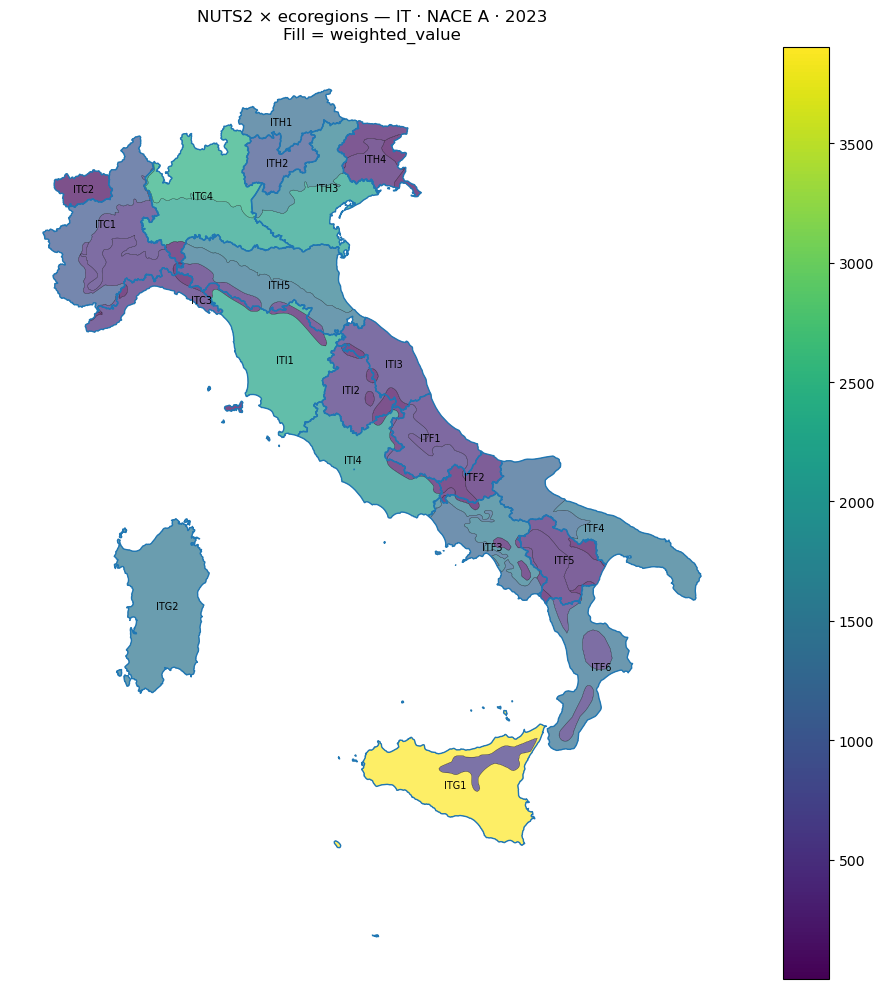

In [33]:
# ===== Visualize NUTS2×ecoregion weighted areas (from your `merged` GeoDataFrame) =====
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# --- EDIT THESE ---
COUNTRY = "IT"       # 2-letter ISO from NUTS2 prefix, e.g. "TR","PT","RO","BG","MK","ME","CY", ...
TARGET_NACE = "A"
TARGET_YEAR = 2023
OUT_PNG = f"map_merged_{COUNTRY}_nace{TARGET_NACE}_{TARGET_YEAR}.png"

# ---- If `merged` is already a GeoDataFrame in memory, keep this line only:
m = merged.copy()

# ---- If instead you have it on disk (uncomment ONE of these):
# m = gpd.read_file("merged.gpkg")       # if you wrote it to a GeoPackage earlier
# m = gpd.read_file("merged.geojson")    # or a GeoJSON with geometries

# Basic hygiene
m = m.dropna(subset=["NUTS_ID", "nace_code", "added_value", "year_used", "ECO_ID", "geometry"])
# Filter: country (from NUTS prefix), sector, year
m["country"] = m["NUTS_ID"].str[:2]
M = m[(m["country"] == COUNTRY) & (m["nace_code"] == TARGET_NACE)].copy()

# ensure it's a GeoDataFrame (important for dissolve() and plotting)
if not isinstance(M, gpd.GeoDataFrame):
    M = gpd.GeoDataFrame(M, geometry="geometry", crs="EPSG:3035")  # or the CRS used in your overlay
    
# Drop rows where overlay was missing (ECO_ID/geometry NaN) to avoid plotting blanks
M = M.dropna(subset=["geometry", "ECO_ID", "share_in_nuts"])

if M.empty:
    raise ValueError("No rows to plot after filtering. Check COUNTRY / NACE / YEAR or ensure overlay is built at NUTS2.")

# Normalize a plotting weight so color scale is meaningful even if magnitudes differ
# (this keeps true proportionality between intersections inside the chosen filter)
M["plot_weight"] = M["weighted_value"]

# Build NUTS2 outlines by dissolving intersections per NUTS2
nuts2_outline = M[["NUTS_ID", "geometry"]].dissolve(by="NUTS_ID", as_index=False)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Fill the NUTS2×ecoregion slices by weighted_value (continuous legend)
# (No explicit colors set; uses default colormap)
M.plot(ax=ax, column="plot_weight", legend=True, alpha=0.7, linewidth=0.2, edgecolor="k")

# Draw NUTS2 boundaries on top
nuts2_outline.boundary.plot(ax=ax, linewidth=1.0)

# Optional: label NUTS2 codes
try:
    nuts2_outline["rep_pt"] = nuts2_outline.representative_point()
    for _, row in nuts2_outline.iterrows():
        x, y = row["rep_pt"].x, row["rep_pt"].y
        ax.text(x, y, row["NUTS_ID"], fontsize=7, ha="center", va="center")
except Exception:
    pass

ax.set_title(f"NUTS2 × ecoregions — {COUNTRY} · NACE {TARGET_NACE} · {TARGET_YEAR}\nFill = weighted_value")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=200, bbox_inches="tight")
print(f"Saved: {OUT_PNG}")


In [34]:
merged

,nace_code,NUTS_ID,added_value,year_used,ECO_ID,geometry,share_in_nuts,weighted_value
0,A,BE10,1.10,2023,80402.0,"POLYGON ((3929661.851 3101971.154, 3929331.385...",1.000000,1.100000
1,A,BE21,965.90,2023,80402.0,"MULTIPOLYGON (((3961511.091 3161368.032, 39616...",0.993178,959.310989
2,A,BE22,454.60,2023,80402.0,"MULTIPOLYGON (((4024448.237 3081606.231, 40253...",1.000000,454.600000
3,A,BE23,620.90,2023,80402.0,"MULTIPOLYGON (((3923873.296 3137990.909, 39233...",0.994753,617.642357
4,A,BE24,294.90,2023,80402.0,"POLYGON ((3979738.831 3111891.725, 3979280.841...",1.000000,294.900000
...,...,...,...,...,...,...,...,...
3743,L,TRC3,460.03,2023,80420.0,"MULTIPOLYGON (((6950767.321 2150310.194, 69513...",0.133306,61.324924
3744,L,TRC3,460.03,2023,80446.0,"POLYGON ((7045308.045 2258104.115, 7047441.813...",0.334126,153.708054
3745,L,TRC3,460.03,2023,80805.0,"MULTIPOLYGON (((7011995.928 2281679.3, 7013016...",0.070219,32.302621
3746,L,TRC3,460.03,2023,80812.0,"POLYGON ((6961364.682 2070655.871, 6958937.71 ...",0.001452,0.667837


In [35]:
import pandas as pd

# biodiversity CFs
cf = pd.read_csv("/Users/romain/GitHub/edges/dev/Land use - Biodiversity/data/CF_domain.csv", encoding="latin-1")

# --- Clean / align join keys ---
# Rename to have same column name
cf = cf.rename(columns={"eco_id": "ECO_ID"})
# Make sure type matches (int vs float)
cf["ECO_ID"] = cf["ECO_ID"].astype(float)
merged["ECO_ID"] = merged["ECO_ID"].astype(float)

# --- Merge on ecoregion ID ---
merged_cf = pd.merge(merged, cf[["ECO_ID", "CF_occ_avg_glo"]], on="ECO_ID", how="left")

# --- Compute weighted CF per row ---
merged_cf["weighted_CF"] = merged_cf["CF_occ_avg_glo"] * merged_cf["weighted_value"]

# --- Aggregate: value-added–weighted CF per NACE code ---
result = (
    merged_cf.groupby("nace_code", as_index=False)
    .agg(total_added_value=("added_value", "sum"),
         total_weighted_CF=("weighted_CF", "sum"))
)
result["CF_weighted_avg"] = result["total_weighted_CF"] / result["total_added_value"]

# --- Optional: keep NUTS2 breakdown if you need regional CFs ---
result_nuts = (
    merged_cf.groupby(["nace_code", "NUTS_ID"], as_index=False)
    .agg(weighted_CF=("weighted_CF", "sum"),
         total_value=("added_value", "sum"))
)
result_nuts["CF_weighted_avg"] = result_nuts["weighted_CF"] / result_nuts["total_value"]

# --- Save results ---
result.to_csv("CF_weighted_by_NACE.csv", index=False)
result_nuts.to_csv("CF_weighted_by_NACE_NUTS2.csv", index=False)

print(result.head())


  nace_code  total_added_value  total_weighted_CF  CF_weighted_avg
0         A        13585558.81       1.009006e-08     7.427050e-16
1         C        86310317.50       4.702997e-08     5.448939e-16
2         F        29865291.48       2.127657e-08     7.124179e-16
3         J        27642393.37       1.781599e-08     6.445169e-16
4         K        23663035.55       1.771173e-08     7.484978e-16


In [36]:
import pandas as pd

# --- Prep / align keys ---
cf = cf.rename(columns={"eco_id": "ECO_ID"})
merged["ECO_ID"] = pd.to_numeric(merged["ECO_ID"], errors="coerce")
cf["ECO_ID"]     = pd.to_numeric(cf["ECO_ID"], errors="coerce")
merged["added_value"]    = pd.to_numeric(merged["added_value"], errors="coerce")
merged["weighted_value"] = pd.to_numeric(merged["weighted_value"], errors="coerce")

# Country (ISO-2) from NUTS2
merged["country"] = merged["NUTS_ID"].astype(str).str[:2]

# --- Denominator: total added value for (nace_code, country) ---
# De-duplicate NUTS2 rows to avoid counting the same region multiple times (it appears once per eco slice)
base = merged[["nace_code","country","NUTS_ID","added_value"]].drop_duplicates()
denom = (base.groupby(["nace_code","country"], as_index=False)["added_value"]
              .sum()
              .rename(columns={"added_value": "added_value_country"}))

# --- Numerator: added value within each (NUTS2 × ECO_ID) for the NACE ---
# (sum the pieces for the same ECO_ID inside a NUTS2)
eco_val = (merged.groupby(["nace_code","country","NUTS_ID","ECO_ID"], as_index=False)["weighted_value"]
                 .sum()
                 .rename(columns={"weighted_value": "added_value_in_ecoregion"}))

# --- Join denominator and CFs (preserving habitat fields) ---
cf_cols_to_keep = ["ECO_ID", "species_group", "kingdom", "habitat_id", "habitat", "CF_occ_avg_glo"]
# Compute country total directly from merged values (one unique per NUTS2 & NACE)
denom_fixed = (
    merged.groupby(["nace_code", "country", "NUTS_ID"], as_index=False)["added_value"].first()
           .groupby(["nace_code", "country"], as_index=False)["added_value"].sum()
           .rename(columns={"added_value": "added_value_country"})
)

# Then redo the join:
out = (eco_val
       .merge(denom_fixed, on=["nace_code","country"], how="left")
       .merge(cf[cf_cols_to_keep], on="ECO_ID", how="left"))

# And recompute weights:
out["weight_vs_country"] = out["added_value_in_ecoregion"] / out["added_value_country"]
out["CF_weighted_vs_country"] = out["CF_occ_avg_glo"] * out["weight_vs_country"]


# --- Final tidy columns ---
out = out[[
    "nace_code", "country", "NUTS_ID", "ECO_ID",
    "species_group", "kingdom", "habitat_id", "habitat",
    "added_value_in_ecoregion", "added_value_country",
    "weight_vs_country", "CF_occ_avg_glo", "CF_weighted_vs_country"
]]

# Optional sanity: within each (nace_code, country), weights should sum ~1 (allow tiny gaps due to missing CFs)
# print(out.groupby(["nace_code","country"])["weight_vs_country"].sum().round(6))

out.to_csv("nace_nuts2_ecoregion_habitat_cf_weighted.csv", index=False)
print("Wrote: nace_nuts2_ecoregion_habitat_cf_weighted.csv")


Wrote: nace_nuts2_ecoregion_habitat_cf_weighted.csv


In [37]:
out

,nace_code,country,NUTS_ID,ECO_ID,species_group,kingdom,habitat_id,habitat,added_value_in_ecoregion,added_value_country,weight_vs_country,CF_occ_avg_glo,CF_weighted_vs_country
0,A,AL,AL01,80404.0,Eukaryota,NaN,2.0,Cropland_Intense,40.788294,2782.61,0.014658,1.544215e-15,2.263555e-17
1,A,AL,AL01,80404.0,Eukaryota,NaN,3.0,Cropland_Light,40.788294,2782.61,0.014658,1.244039e-15,1.823548e-17
2,A,AL,AL01,80404.0,Eukaryota,NaN,4.0,Cropland_Minimal,40.788294,2782.61,0.014658,1.109908e-15,1.626934e-17
3,A,AL,AL01,80404.0,Eukaryota,NaN,5.0,Managed_forest_Intense,40.788294,2782.61,0.014658,9.000949e-16,1.319385e-17
4,A,AL,AL01,80404.0,Eukaryota,NaN,6.0,Managed_forest_Light,40.788294,2782.61,0.014658,4.197087e-16,6.152210e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54517,L,TR,TRC3,81207.0,Eukaryota,NaN,12.0,Plantation_Light,212.026564,40135.87,0.005283,4.672826e-15,2.468523e-17
54518,L,TR,TRC3,81207.0,Eukaryota,NaN,13.0,Plantation_Minimal,212.026564,40135.87,0.005283,1.965373e-15,1.038252e-17
54519,L,TR,TRC3,81207.0,Eukaryota,NaN,14.0,Urban_Intense,212.026564,40135.87,0.005283,5.326095e-15,2.813627e-17
54520,L,TR,TRC3,81207.0,Eukaryota,NaN,15.0,Urban_Light,212.026564,40135.87,0.005283,3.029724e-15,1.600518e-17


In [38]:
# Share of rows with missing CFs
missing_cf_share = out["CF_occ_avg_glo"].isna().mean()
print(f"⚠️ Fraction of rows missing CF_occ_avg_glo: {missing_cf_share:.2%}")


⚠️ Fraction of rows missing CF_occ_avg_glo: 0.36%


In [39]:
check_weights = out.groupby(["nace_code", "country"])["weight_vs_country"].sum().reset_index()
check_weights.columns = ["nace_code", "country", "sum_weight"]
print(check_weights.sort_values("sum_weight").head(10))


    nace_code country  sum_weight
127         J      PT    3.956407
161         K      PT    4.182655
27          A      PT    4.970538
194         L      PT    5.652720
60          C      PT    6.840275
93          F      PT    7.105450
124         J      NL    9.801973
158         K      NL    9.959308
90          F      NL   10.273667
191         L      NL   10.415959


In [40]:
print("Weights outside [0,1]:", (~out["weight_vs_country"].between(0, 1)).sum())
print(out["weight_vs_country"].describe())


Weights outside [0,1]: 0
count    54522.000000
mean         0.052801
std          0.123211
min          0.000000
25%          0.002943
50%          0.013777
75%          0.046315
max          1.000000
Name: weight_vs_country, dtype: float64


In [41]:
eco_sum = out.groupby(["nace_code","country"])["added_value_in_ecoregion"].sum()
denom_sum = out.drop_duplicates(["nace_code","country"]) \
               .set_index(["nace_code","country"])["added_value_country"]
balance = (eco_sum / denom_sum).reset_index(name="ratio")
print(balance.sort_values("ratio").head(10))


    nace_code country      ratio
127         J      PT   3.956407
161         K      PT   4.182655
27          A      PT   4.970538
194         L      PT   5.652720
60          C      PT   6.840275
93          F      PT   7.105450
124         J      NL   9.801973
158         K      NL   9.959308
90          F      NL  10.273667
191         L      NL  10.415959


In [42]:
import pandas as pd
import geopandas as gpd

# overlay should be your NUTS2×ECO intersections with 'share_in_nuts'
def check_overlay(overlay):
    # sum of ecoregion shares per NUTS2 (should be ~1, <=1 if water is included)
    s = overlay.groupby("NUTS_ID")["share_in_nuts"].sum().sort_values(ascending=False)
    print("Top NUTS2 by sum of shares (bad if >> 1):")
    print(s.head(20))
    return s

_ = check_overlay(overlay)


Top NUTS2 by sum of shares (bad if >> 1):
NUTS_ID
ITC1    1.0
ES42    1.0
RS11    1.0
TRA2    1.0
UKE3    1.0
FRK1    1.0
FRF2    1.0
FRC2    1.0
FRC1    1.0
FRB0    1.0
RO12    1.0
TRB2    1.0
ES43    1.0
ES41    1.0
ES22    1.0
UKD3    1.0
UKG1    1.0
HR02    1.0
UKG3    1.0
UKI3    1.0
Name: share_in_nuts, dtype: float64


In [43]:
out

,nace_code,country,NUTS_ID,ECO_ID,species_group,kingdom,habitat_id,habitat,added_value_in_ecoregion,added_value_country,weight_vs_country,CF_occ_avg_glo,CF_weighted_vs_country
0,A,AL,AL01,80404.0,Eukaryota,NaN,2.0,Cropland_Intense,40.788294,2782.61,0.014658,1.544215e-15,2.263555e-17
1,A,AL,AL01,80404.0,Eukaryota,NaN,3.0,Cropland_Light,40.788294,2782.61,0.014658,1.244039e-15,1.823548e-17
2,A,AL,AL01,80404.0,Eukaryota,NaN,4.0,Cropland_Minimal,40.788294,2782.61,0.014658,1.109908e-15,1.626934e-17
3,A,AL,AL01,80404.0,Eukaryota,NaN,5.0,Managed_forest_Intense,40.788294,2782.61,0.014658,9.000949e-16,1.319385e-17
4,A,AL,AL01,80404.0,Eukaryota,NaN,6.0,Managed_forest_Light,40.788294,2782.61,0.014658,4.197087e-16,6.152210e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54517,L,TR,TRC3,81207.0,Eukaryota,NaN,12.0,Plantation_Light,212.026564,40135.87,0.005283,4.672826e-15,2.468523e-17
54518,L,TR,TRC3,81207.0,Eukaryota,NaN,13.0,Plantation_Minimal,212.026564,40135.87,0.005283,1.965373e-15,1.038252e-17
54519,L,TR,TRC3,81207.0,Eukaryota,NaN,14.0,Urban_Intense,212.026564,40135.87,0.005283,5.326095e-15,2.813627e-17
54520,L,TR,TRC3,81207.0,Eukaryota,NaN,15.0,Urban_Light,212.026564,40135.87,0.005283,3.029724e-15,1.600518e-17


In [44]:
len(out)

54522

In [45]:
occupation_flows = {
    'Occupation, annual crop': 'Cropland_Intense',
    'Occupation, annual crop, flooded crop': 'Cropland_Intense',
    'Occupation, annual crop, greenhouse': 'Urban_Light',
    'Occupation, annual crop, irrigated': 'Cropland_Intense',
    'Occupation, annual crop, irrigated, extensive': 'Cropland_Light',
    'Occupation, annual crop, irrigated, intensive': 'Cropland_Intense',
    'Occupation, annual crop, non-irrigated': 'Cropland_Intense',
    'Occupation, annual crop, non-irrigated, extensive': 'Cropland_Minimal',
    'Occupation, annual crop, non-irrigated, intensive': 'Cropland_Intense',
    'Occupation, arable land, unspecified use': 'Cropland_Intense',
    # 'Occupation, arable, conservation tillage (obsolete)': '',
    # 'Occupation, arable, conventional tillage (obsolete)': '',
    # 'Occupation, arable, reduced tillage (obsolete)': '',
    # 'Occupation, bare area (non-use)': '',
    'Occupation, construction site': 'Urban_Intense',
    'Occupation, cropland fallow (non-use)': 'Cropland_Minimal',
    'Occupation, dump site': 'Urban_Intense',
    'Occupation, field margin/hedgerow': 'Cropland_Minimal',
    'Occupation, forest, extensive': 'Pasture_Light',
    'Occupation, forest, intensive': 'Managed_forest_Intense',
    'Occupation, forest, primary (non-use)': 'Managed_forest_Minimal',
    'Occupation, forest, secondary (non-use)': 'Pasture_Light',
    'Occupation, forest, unspecified': 'Managed_forest_Intense',
    'Occupation, grassland, natural (non-use)': 'Pasture_Minimal',
    'Occupation, grassland, natural, for livestock grazing': 'Pasture_Minimal',
    'Occupation, heterogeneous, agricultural': 'Cropland_Minimal',
    'Occupation, industrial area': 'Urban_Intense',
    # 'Occupation, inland waterbody, unspecified': '',
    # 'Occupation, lake, artificial': '',
    # 'Occupation, lake, natural (non-use)': '',
    'Occupation, mineral extraction site': 'Urban_Intense',
    'Occupation, pasture, man made': 'Pasture_Intense',
    'Occupation, pasture, man made, extensive': 'Pasture_Light',
    'Occupation, pasture, man made, intensive': 'Pasture_Intense',
    'Occupation, permanent crop': 'Cropland_Intense',
    'Occupation, permanent crop, irrigated': 'Cropland_Intense',
    'Occupation, permanent crop, irrigated, extensive': 'Cropland_Light',
    'Occupation, permanent crop, irrigated, intensive': 'Cropland_Intense',
    'Occupation, permanent crop, non-irrigated': 'Cropland_Intense',
    'Occupation, permanent crop, non-irrigated, extensive': 'Cropland_Minimal',
    'Occupation, permanent crop, non-irrigated, intensive': 'Cropland_Intense',
    # 'Occupation, river, artificial': '',
    # 'Occupation, river, natural (non-use)': '',
    # 'Occupation, seabed, drilling and mining': '',
    # 'Occupation, seabed, infrastructure': '',
    # 'Occupation, seabed, natural (non-use)': '',
    # 'Occupation, seabed, unspecified': '',
    'Occupation, shrub land, sclerophyllous': 'Managed_forest_Minimal',
    # 'Occupation, snow and ice (non-use)': '',
    'Occupation, traffic area, rail network': 'Urban_Intense',
    'Occupation, traffic area, rail/road embankment': 'Urban_Light',
    'Occupation, traffic area, road network': 'Urban_Intense',
    'Occupation, unspecified': 'Urban_Intense',
    'Occupation, unspecified, natural (non-use)': 'Pasture_Minimal',
    'Occupation, urban, continuously built': 'Urban_Intense',
    'Occupation, urban, discontinuously built': 'Urban_Light',
    'Occupation, urban, green area': 'Urban_Minimal',
    'Occupation, urban/industrial fallow (non-use)': 'Urban_Light',
    # 'Occupation, wetland, coastal (non-use)': '',
    # 'Occupation, wetland, inland (non-use)': '',
}

rev_occ_flows = {v: k for k, v in occupation_flows.items()}

In [47]:
rev_occ_flows

{'Cropland_Intense': 'Occupation, permanent crop, non-irrigated, intensive',
 'Urban_Light': 'Occupation, urban/industrial fallow (non-use)',
 'Cropland_Light': 'Occupation, permanent crop, irrigated, extensive',
 'Cropland_Minimal': 'Occupation, permanent crop, non-irrigated, extensive',
 'Urban_Intense': 'Occupation, urban, continuously built',
 'Pasture_Light': 'Occupation, pasture, man made, extensive',
 'Managed_forest_Intense': 'Occupation, forest, unspecified',
 'Managed_forest_Minimal': 'Occupation, shrub land, sclerophyllous',
 'Pasture_Minimal': 'Occupation, unspecified, natural (non-use)',
 'Pasture_Intense': 'Occupation, pasture, man made, intensive',
 'Urban_Minimal': 'Occupation, urban, green area'}

In [48]:
out["elementary flow"] = out["habitat"].map(rev_occ_flows)

In [52]:
out = out.dropna(subset="elementary flow")

In [53]:
out

,nace_code,country,NUTS_ID,ECO_ID,species_group,kingdom,habitat_id,habitat,added_value_in_ecoregion,added_value_country,weight_vs_country,CF_occ_avg_glo,CF_weighted_vs_country,elementary flow
0,A,AL,AL01,80404.0,Eukaryota,NaN,2.0,Cropland_Intense,40.788294,2782.61,0.014658,1.544215e-15,2.263555e-17,"Occupation, permanent crop, non-irrigated, int..."
1,A,AL,AL01,80404.0,Eukaryota,NaN,3.0,Cropland_Light,40.788294,2782.61,0.014658,1.244039e-15,1.823548e-17,"Occupation, permanent crop, irrigated, extensive"
2,A,AL,AL01,80404.0,Eukaryota,NaN,4.0,Cropland_Minimal,40.788294,2782.61,0.014658,1.109908e-15,1.626934e-17,"Occupation, permanent crop, non-irrigated, ext..."
3,A,AL,AL01,80404.0,Eukaryota,NaN,5.0,Managed_forest_Intense,40.788294,2782.61,0.014658,9.000949e-16,1.319385e-17,"Occupation, forest, unspecified"
5,A,AL,AL01,80404.0,Eukaryota,NaN,7.0,Managed_forest_Minimal,40.788294,2782.61,0.014658,1.192167e-16,1.747513e-18,"Occupation, shrub land, sclerophyllous"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54514,L,TR,TRC3,81207.0,Eukaryota,NaN,9.0,Pasture_Light,212.026564,40135.87,0.005283,4.175476e-15,2.205787e-17,"Occupation, pasture, man made, extensive"
54515,L,TR,TRC3,81207.0,Eukaryota,NaN,10.0,Pasture_Minimal,212.026564,40135.87,0.005283,2.886408e-15,1.524809e-17,"Occupation, unspecified, natural (non-use)"
54519,L,TR,TRC3,81207.0,Eukaryota,NaN,14.0,Urban_Intense,212.026564,40135.87,0.005283,5.326095e-15,2.813627e-17,"Occupation, urban, continuously built"
54520,L,TR,TRC3,81207.0,Eukaryota,NaN,15.0,Urban_Light,212.026564,40135.87,0.005283,3.029724e-15,1.600518e-17,"Occupation, urban/industrial fallow (non-use)"


In [57]:
out["country"] = out["NUTS_ID"].str[:2]

/var/folders/cn/pys1j9rn0y7djkhv3hfdtrs00000gn/T/ipykernel_50395/2074796127.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out["country"] = out["NUTS_ID"].str[:2]


In [59]:
out.columns

Index(['nace_code', 'country', 'NUTS_ID', 'ECO_ID', 'species_group', 'kingdom',
       'habitat_id', 'habitat', 'added_value_in_ecoregion',
       'added_value_country', 'weight_vs_country', 'CF_occ_avg_glo',
       'CF_weighted_vs_country', 'elementary flow'],
      dtype='object')

In [79]:
def generate_occupation_json():
    """Generate JSON for occupation flows"""
    
    exchanges = []
    # Get all countries
    countries_list = out['country'].unique()

    nace_to_cpc = {
        "A": [
            
            "01", "02", "03", "04"
        ],
        "C": [
            "1", "2", "3", "4"
        ],
        "F": [
            "5"
        ],
        "J": [
            "8"
        ],
        "K": [
            "7"
        ]
    }

    for habitat_type in out["habitat"].unique():
        for country in countries_list:
            for nace_code in out["nace_code"].unique():
                if nace_code == "L":
                    continue
                    
                # Get country-level CF from cfs_country
                country_cf_row = out.loc[
                    (out['country'] == country) &
                    (out['habitat'] == habitat_type) &
                    (out['nace_code'] == nace_code),
                    :
                ]

                
                # If no country-level CF available, skip this country-habitat combination
                if len(country_cf_row) == 0:
                    continue
                
                # Get the country-level CF value
                country_cf_value = country_cf_row['CF_weighted_vs_country'].sum()
                
                
                # Prepare uncertainty parameters from ecoregion data
                values = country_cf_row['CF_occ_avg_glo'].values 
                weights = country_cf_row['weight_vs_country'].values

                
                exchange = {
                    "supplier": {
                        "name": country_cf_row["elementary flow"].iloc[0],
                        "categories": ["natural resource", "land"],
                        "matrix": "biosphere"
                    },
                    "consumer": {
                        "location": country_cf_row["country"].iloc[0],
                        "classifications": {
                            "CPC": nace_to_cpc[nace_code]
                        },
                        "matrix": "technosphere"
                    },
                    "value": float(country_cf_value),
                    "weight": country_cf_row["added_value_country"].iloc[0],
                    "uncertainty": {
                        "distribution": "discrete_empirical",
                        "parameters": {
                            "values": [float(v) for v in values],
                            "weights": [float(w) for w in weights]
                        }
                    }
                }
                
                exchanges.append(exchange)
    
    output = {
        "name": "ecoinvent 3.10/3.11 - GLAM3 - Land occupation, biodiversity damage, Added value weighting",
        "unit": "PDF.yr",
        "version": "0.1",
        "description": "Characterization factors for land occupation impacts on biodiversity, considering global species loss. Based on Scherer et al. 2023: https://doi.org/10.5281/zenodo.10114492",
        "strategies": [
            "map_exchanges",
            "map_aggregate_locations",
            "map_dynamic_locations",
            "map_contained_locations",
            "map_remaining_locations_to_global"
        ],
        "exchanges": exchanges
    }
    
    return output
output = generate_occupation_json()

In [83]:
import json
with open("GLAM3_biodiversity_occupation_average_eukaryota_NACE_weighted.json", "w") as f:
    json.dump(output, f, indent=2)

In [1]:
import pandas as pd

from edges import EdgeLCIA, get_available_methods, setup_package_logging
import logging
import bw2data, bw2io

# we want the logger to log things into edges.log
setup_package_logging(level=logging.INFO)
# if you want full debug:
#setup_package_logging(level=logging.DEBUG)

/opt/homebrew/Caskroom/miniforge/base/envs/edges/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


14:55:44+0200 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


In [26]:
bw2data.projects.set_current("bw25_ei310")
bw2data.databases
eidb=bw2data.Database("ecoinvent-3.10-cutoff")
act = [act for act in eidb if act["location"] == "FR"][0]
act
# bw2data.projects.set_current("ecoinvent-3.10-cutoff")

'market for electricity, low voltage' (kilowatt hour, FR, None)

In [27]:
LCA = EdgeLCIA(
    demand={act: 1}, # <- we define a functional unit
    method="GLAM3_biodiversity_occupation_average_eukaryota_NACE_weighted.json",
    #use_distributions=True, # <- we want to consider variability across ecoregions
    #iterations=10000 # <- we specific the number of iterations
)

# apply strategies
#LCA.apply_strategies()
LCA.lci()
LCA.map_exchanges()
LCA.evaluate_cfs()
LCA.lcia()

df = LCA.generate_cf_table()

/opt/homebrew/Caskroom/miniforge/base/envs/edges/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 5.51e+12)
  warnings.warn(msg, UmfpackWarning)
Mapping exchanges: 100%|██████████████████| 1848/1848 [00:01<00:00, 1111.19it/s]


In [30]:
df.loc[df["consumer name"].str.contains("building")]

,supplier name,supplier categories,consumer name,consumer reference product,consumer location,amount,CF,impact


In [31]:
df.groupby("consumer location")["CF"].unique()

consumer location
AT                              [2.295340166779409e-16]
BE                              [8.650820697989539e-17]
CH                             [1.5708589514701973e-15]
CZ                              [8.176111460345133e-17]
DE    [1.036307144096409e-16, 7.562997251701684e-16,...
ES                              [6.606421621016221e-16]
FR                             [1.8241134598644635e-16]
HR                             [1.5099829831001717e-16]
IT                             [3.1372037043457625e-16]
NL                              [6.682156167528584e-17]
PL                              [4.041123360423109e-17]
PT                             [3.3832001704945875e-16]
SK                              [9.493812358189033e-17]
Name: CF, dtype: object

In [32]:
df

,supplier name,supplier categories,consumer name,consumer reference product,consumer location,amount,CF,impact
0,"Occupation, shrub land, sclerophyllous","(natural resource, land)","treatment of hard coal ash, residual material ...",hard coal ash,AT,4.756099e-13,2.295340e-16,1.091687e-28
1,"Occupation, shrub land, sclerophyllous","(natural resource, land)","treatment of hard coal ash, residual material ...",hard coal ash,BE,2.030051e-12,8.650821e-17,1.756160e-28
2,"Occupation, shrub land, sclerophyllous","(natural resource, land)","treatment of hard coal ash, residual material ...",hard coal ash,CZ,8.793394e-11,8.176111e-17,7.189577e-27
3,"Occupation, shrub land, sclerophyllous","(natural resource, land)","treatment of hard coal ash, residual material ...",hard coal ash,DE,4.213893e-10,1.036307e-16,4.366888e-26
4,"Occupation, shrub land, sclerophyllous","(natural resource, land)",burnt shale production,burnt shale,DE,1.280672e-13,1.036307e-16,1.327169e-29
5,"Occupation, shrub land, sclerophyllous","(natural resource, land)","treatment of waste, from silicon wafer product...","waste, from silicon wafer production, inorganic",DE,1.415024e-10,1.036307e-16,1.466399e-26
6,"Occupation, shrub land, sclerophyllous","(natural resource, land)","treatment of hard coal ash, residual material ...",hard coal ash,ES,6.528556e-09,6.606422e-16,4.313039e-24
7,"Occupation, shrub land, sclerophyllous","(natural resource, land)","treatment of hard coal ash, residual material ...",hard coal ash,FR,3.854382e-09,1.824113e-16,7.030830e-25
8,"Occupation, shrub land, sclerophyllous","(natural resource, land)","treatment of hard coal ash, residual material ...",hard coal ash,HR,2.458225e-11,1.509983e-16,3.711878e-27
9,"Occupation, shrub land, sclerophyllous","(natural resource, land)","treatment of hard coal ash, residual material ...",hard coal ash,IT,1.382165e-10,3.137204e-16,4.336132e-26
